In [2]:
import torch
import spacy
from checklist.perturb import Perturb
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from datasets import Dataset
import os.path
import sklearn
from transformers import DataCollatorForTokenClassification
import evaluate
import numpy as np
from transformers import pipeline
import wandb
import matplotlib.pyplot as plt


In [3]:
def read_iob2_file(path):
    """
    read in conll file
    
    :param path: path to read from
    :returns: list with sequences of words and labels for each sentence
    """
    data = []
    current_words = []
    current_tags = []

    for line in open(path, encoding='utf-8'):
        line = line.strip()
        if line:
            if line[0] == '#':
                continue # skip comments
            tok = line.split('\t')

            current_words.append(tok[1])
            current_tags.append(tok[2])
        else:
            if current_words:  # skip empty lines
                data.append((current_words, current_tags))
            current_words = []
            current_tags = []

    # check for last one
    if current_tags != []:
        data.append((current_words, current_tags))
    return data

train_data= read_iob2_file('data//en_ewt-ud-train.iob2')
dev_data = read_iob2_file('data//en_ewt-ud-dev.iob2')

In [4]:
# Hyperparameters
DIM_EMBEDDING = 100
LSTM_HIDDEN = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 5
PAD = '<PAD>'

In [5]:
class Vocab():
    def __init__(self, pad_unk):
        """
        A convenience class that can help store a vocabulary
        and retrieve indices for inputs.
        """
        self.pad_unk = pad_unk
        self.word2idx = {self.pad_unk: 0}
        self.idx2word = [self.pad_unk]

    def getIdx(self, word, add=False):
        if word not in self.word2idx:
            if add:
                self.word2idx[word] = len(self.idx2word)
                self.idx2word.append(word)
            else:
                return self.word2idx[self.pad_unk]
        return self.word2idx[word]

    def getWord(self, idx):
        return self.idx2word[idx]


max_len = max([len(x[0]) for x in train_data ])

# Create vocabularies for both the tokens
# and the tags
token_vocab = Vocab(PAD)
label_vocab = Vocab(PAD)
id_to_token = [PAD]

for tokens, tags in train_data:
    for token in tokens:
        token_vocab.getIdx(token, True)
    for tag in tags:
        label_vocab.getIdx(tag, True)

NWORDS = len(token_vocab.idx2word)
NTAGS = len(label_vocab.idx2word)
print(label_vocab.idx2word)

# convert text data with labels to indices
def data2feats(inputData, word_vocab, label_vocab):
    feats = torch.zeros((len(inputData), max_len), dtype=torch.long)
    labels = torch.zeros((len(inputData), max_len), dtype=torch.long)
    for sentPos, sent in enumerate(inputData):
        for wordPos, word in enumerate(sent[0][:max_len]):
            wordIdx = word_vocab.getIdx(word)
            feats[sentPos][wordPos] = wordIdx
        for labelPos, label in enumerate(sent[1][:max_len]):
            labelIdx = label_vocab.getIdx(label)
            labels[sentPos][labelPos] = labelIdx
    return feats, labels

train_features, train_labels = data2feats(train_data, token_vocab, label_vocab)
dev_feats, dev_labels = data2feats(dev_data, token_vocab, label_vocab)

['<PAD>', 'O', 'B-LOC', 'I-LOC', 'B-PER', 'B-ORG', 'I-ORG', 'I-PER']


### TAG DISTRIBUTION

{'O': 194219, 'B-LOC': 2712, 'I-LOC': 877, 'B-PER': 2874, 'I-PER': 1294, 'B-ORG': 1436, 'I-ORG': 1167}
204579


([<matplotlib.axis.XTick at 0x15008a7d0>,
 [Text(0, 0, 'O'),
  Text(1, 0, 'B-LOC'),
  Text(2, 0, 'I-LOC'),
  Text(3, 0, 'B-PER'),
  Text(4, 0, 'I-PER'),
  Text(5, 0, 'B-ORG'),
  Text(6, 0, 'I-ORG')])

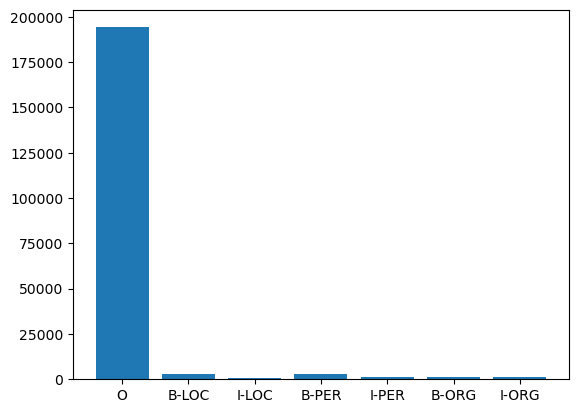

In [9]:
counts = {
    "O": 0,
    "B-LOC": 0,
    "I-LOC": 0,
    "B-PER": 0,
    "I-PER": 0,
    "B-ORG": 0,
    "I-ORG": 0,
}

for sentence in train_data:
    for tag in sentence[1]:
        if tag == 'O':
            counts['O'] += 1
        elif tag == 'B-LOC':
            counts['B-LOC'] += 1
        elif tag == 'I-LOC':
            counts['I-LOC'] += 1
        elif tag == 'B-PER':
            counts['B-PER'] += 1
        elif tag == 'I-PER':
            counts['I-PER'] += 1
        elif tag == 'B-ORG':
            counts['B-ORG'] += 1
        elif tag == 'I-ORG':
            counts['I-ORG'] += 1
        else:
            print('unsupported tag')
    
print(counts)
total = 0
for value in counts.values():
    total += value
print(total)
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()))

# Our data

In [137]:
# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]="nlp-project"

# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"]="true"

# turn off watch to log faster
os.environ["WANDB_WATCH"]="false"

In [142]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def align_labels(tokenized_input, labels):
  word_ids = tokenized_input.word_ids()
  aligned_labels = []
  previous_word_idx = None
  for word_idx in word_ids:
    if word_idx is None or word_idx == tokenizer.pad_token_id:
      aligned_labels.append(-100)
    elif word_idx != previous_word_idx:
      aligned_labels.append(labels[word_idx])
    else:
      aligned_labels.append(-100)
    previous_word_idx = word_idx
  return aligned_labels

# TRAIN DATA
tokenized_train = []
for sentence, labels in train_data:
  tokenized_input = tokenizer(sentence, is_split_into_words=True)
  labelsIndices = []
  for label in labels:
    labelsIndices.append(label_vocab.getIdx(label))
  tokenized_input['labels'] = labelsIndices
  tokenized_train.append(tokenized_input)
print(tokenized_train[0])

for tokenized_input in tokenized_train:
  aligned_labels = align_labels(tokenized_input, tokenized_input['labels'])
  tokenized_input['labels'] = aligned_labels

# DEV DATA
tokenized_dev = []
for sentence, labels in dev_data:
  tokenized_input = tokenizer(sentence, is_split_into_words=True)
  labelsIndices = []
  for label in labels:
    labelsIndices.append(label_vocab.getIdx(label))
  tokenized_input['labels'] = labelsIndices
  tokenized_dev.append(tokenized_input)
print(tokenized_dev[0])

for tokenized_input in tokenized_dev:
  aligned_labels = align_labels(tokenized_input, tokenized_input['labels'])
  tokenized_input['labels'] = aligned_labels

{'input_ids': [101, 2073, 1999, 1996, 2088, 2003, 1045, 19696, 9759, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [1, 1, 1, 1, 1, 2, 1]}
{'input_ids': [101, 2073, 2064, 1045, 2131, 22822, 6895, 25816, 1999, 9925, 3016, 1010, 1045, 2097, 2066, 1996, 23157, 15830, 2828, 1010, 2021, 1045, 2097, 2000, 3046, 2178, 2015, 3531, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [1]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

seqeval = evaluate.load("seqeval")

NameError: name 'DataCollatorForTokenClassification' is not defined

In [140]:
id2label = {
    0: "<PAD>",
    1: "O",
    2: "B-LOC",
    3: "I-LOC",
    4: "B-PER",
    5: "I-PER",
    6: "B-ORG",
    7: "I-ORG",
}
label2id = {
    "<PAD>": 0,
    "O": 1,
    "B-LOC": 2,
    "I-LOC": 3,
    "B-PER": 4,
    "I-PER": 5,
    "B-ORG": 6,
    "I-ORG": 7,
}

In [141]:
model = AutoModelForTokenClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=NTAGS, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [143]:
training_args = TrainingArguments(
    output_dir="testing_bert",
    report_to="wandb",
    learning_rate=2e-5,
    per_device_train_batch_size=4, # with 16 f1 0.66
    per_device_eval_batch_size=4, # with 16 f1 0.66
    num_train_epochs=5, # with 2 f1 0.66
    weight_decay=0.0, # with 0.01 f1 0.66
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()
wandb.finish()

/opt/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: richardkentos (rike). Use `wandb login --relogin` to force relogin


  0%|          | 0/7500 [00:00<?, ?it/s]

{'loss': 0.1216, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.33}


RuntimeError: MPS backend out of memory (MPS allocated: 2.08 GB, other allocations: 6.95 GB, max allowed: 9.07 GB). Tried to allocate 89.42 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [145]:
# Load our finetuned model
fine_tuned = AutoModelForTokenClassification.from_pretrained("full_distilBERT/checkpoint-1568/")

In [132]:
# text = ["The Golden State Warriors are an American professional basketball team based in San Francisco.", "My name is Richard Kentos"]

# from transformers import pipeline
# classifier = pipeline("ner", model="testing_bert/checkpoint-376/")

# for text in classifier(text):
#     print(text)

In [161]:
def get_sentences(path):
    """
    get sentences from conll file
    
    :param path: path to read from
    :returns: list with sequences of words and labels for each sentence
    """
    data = []

    for line in open(path, encoding='utf-8'):
        line = line.strip()
        if line:
            if line[:6] == '# text':
                data.append(line[9:])
    return data

# train_data= read_iob2_file('data//en_ewt-ud-train.iob2')
dev_sentences = get_sentences('data//en_ewt-ud-dev.iob2')
dev_sents_tokenized = []
for sentence in dev_data:
    dev_sents_tokenized.append(sentence[0])

In [147]:
predictionTags = []

def run_eval(sentences, gold_labels):
    match = 0
    total = 0
    for sents, labels in zip(sentences, gold_labels):
        inputs = tokenizer(sents, return_tensors="pt", padding=True, truncation=True, is_split_into_words=True)
        predictionTagOneSentence = []
        with torch.no_grad():
            word_ids = inputs.word_ids()
            # tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].flatten())
            logits = fine_tuned(**inputs).logits
            predictions = torch.argmax(logits, dim=-1).flatten()
            previous_word_idx = None
            for idx, word_idx in enumerate(word_ids):
                if previous_word_idx != word_idx and word_idx is not None:
                    predictionTagOneSentence.append(label_vocab.idx2word[predictions[idx].item()])
                previous_word_idx = word_idx
        predictionTags.append(predictionTagOneSentence)

        # Loop through gold labels
        for goldLabel, predLabel in zip(labels, predictions):
            if goldLabel.item() != 0:
                total += 1
                if goldLabel.item() == predLabel.item():
                    match+= 1
    return(match/total)
    

score = run_eval(dev_sents_tokenized[:len(dev_sents_tokenized)+1], dev_labels[:len(dev_labels)+1])

print('Accuracy for dev data: {:.4f}'.format(score))

print(dev_data[0][0])
print(len(predictionTags))

Accuracy for dev data: 0.8983
['where', 'can', 'I', 'get', 'morcillas', 'in', 'tampa', 'bay', ',', 'I', 'will', 'like', 'the', 'argentinian', 'type', ',', 'but', 'I', 'will', 'to', 'try', 'anothers', 'please', '?']
2001


In [148]:
with open(os.path.join('data', 'new_bert_predictions_dev.iob2'), 'w') as f:
    for sent_tokens, sent_preds in zip(dev_sents_tokenized[:len(dev_sents_tokenized)+1], predictionTags[:len(predictionTags)+1]):
        for index, (token, pred) in enumerate(zip(sent_tokens, sent_preds)):
            f.write(f"{index}\t{token}\t{pred}\n")
        f.write("\n")

# python3 span_f1.py data/new_bert_predictions_dev.iob2 data/en_ewt-ud-dev.iob2  <- run this in terminal to get span f1 score